In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# import the raw dataset
raw_data = pd.read_csv('online_shoppers_intention.csv')
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [3]:
raw_data.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


## Pre-processing the data

In [4]:
# build a new dataframe and change some data type
shopperdata = raw_data
shopperdata[['OperatingSystems','Browser','Region','TrafficType']] = shopperdata[['OperatingSystems','Browser','Region','TrafficType']].astype('object')
shopperdata['Revenue'] = shopperdata['Revenue'].replace([True,False],[1,-1])
shopperdata['Weekend'] = shopperdata['Weekend'].astype("int")
print(shopperdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  object 
 12  Browser                  12330 non-null  object 
 13  Region                   12330 non-null  object 
 14  TrafficType           

In [5]:
# create new dummy variables based on categoricals
X = pd.get_dummies(shopperdata, columns=shopperdata.columns[shopperdata.dtypes == "object"])
X.drop(['Revenue'],axis =1, inplace = True )

# normalize all the numerical columns
X_num = X.iloc[:,0:10]
X_num_norm = (X_num-X_num.min())/(X_num.max()-X_num.min())
X.iloc[:,0:10] = X_num_norm  

# Construct the response variable for classification
y = shopperdata.loc[:,['Revenue']]


print(X.shape, y.shape)
print(X.dtypes)
print(y.dtypes)

(12330, 74) (12330, 1)
Administrative                   float64
Administrative_Duration          float64
Informational                    float64
Informational_Duration           float64
ProductRelated                   float64
                                  ...   
TrafficType_19                     uint8
TrafficType_20                     uint8
VisitorType_New_Visitor            uint8
VisitorType_Other                  uint8
VisitorType_Returning_Visitor      uint8
Length: 74, dtype: object
Revenue    int64
dtype: object


In [6]:
from sklearn.model_selection import train_test_split
# split whole datasize into training and testing (25%)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=1001,stratify = y)
data_train = pd.concat([Xtrain,ytrain],axis=1)

#convert y from datafame to array for future use
ytrain = ytrain.values.ravel()
ytest = ytest.values.ravel()

## Feature Selection

### Correlation

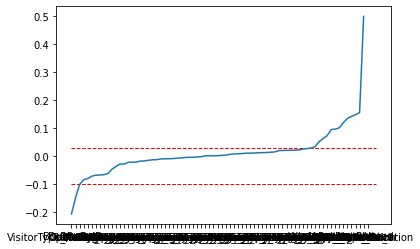

In [7]:
corr = data_train.corr()
corr_y = corr.loc["Revenue"].sort_values()
corr_y.drop(["Revenue"],axis =0, inplace = True )
plt.figure()
plt.plot(corr_y)
plt.hlines(y=(-0.1,0.03),xmin=0,xmax=75,color='r',lw=1,linestyle='dashed')
plt.show()

In [8]:
fea_list_corr = list(corr_y[(corr_y<=-0.1)|(corr_y>=0.03)].index)
fea_list_corr

['ExitRates',
 'BounceRates',
 'VisitorType_Returning_Visitor',
 'TrafficType_20',
 'TrafficType_8',
 'OperatingSystems_2',
 'Informational_Duration',
 'Informational',
 'Administrative_Duration',
 'VisitorType_New_Visitor',
 'TrafficType_2',
 'Administrative',
 'ProductRelated_Duration',
 'ProductRelated',
 'Month_Nov',
 'PageValues']

In [9]:
Xtrain_corr = Xtrain.loc[:,fea_list_corr]
Xtest_corr = Xtest.loc[:,fea_list_corr]
Xtrain_corr.shape

(9247, 16)

### PCA

In [10]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

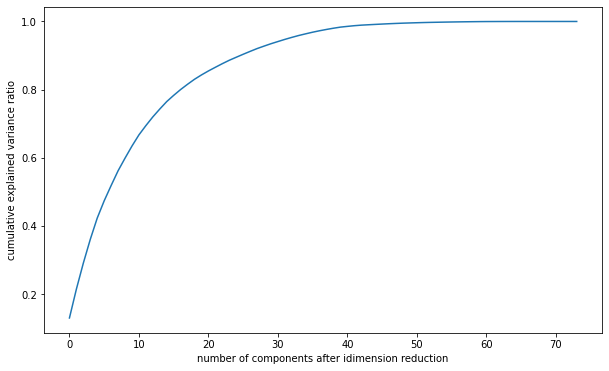

In [11]:
pca_line = PCA().fit(Xtrain)
plt.figure(figsize=[10,6])
plt.plot(np.cumsum(pca_line.explained_variance_ratio_))
plt.xlabel("number of components after idimension reduction")
plt.ylabel("cumulative explained variance ratio")
plt.show()

In [12]:
dim = np.where(np.cumsum(pca_line.explained_variance_ratio_)>0.9)[0][0]
print('num. of component:',dim)
Xtrain_PCA = PCA(dim).fit_transform(Xtrain)
Xtest_PCA = PCA(dim).fit_transform(Xtest)

num. of component: 25


### LASSO

In [13]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.linear_model import LassoCV

#define the list of potential choice of regulator in LASSO
lambdarange = np.logspace(-10,0,200,base=10)
lasso = LassoCV(alphas=lambdarange,cv=10).fit(Xtrain,ytrain)
#lasso_ = LassoCV(eps=0.00001,n_alphas=300,cv=10).fit(Xtrain,ytrain)

In [14]:
lasso_par = lasso.alpha_
lasso_par

0.0005415871378079476

In [15]:
lasso_coef = pd.Series(lasso.coef_, index=X.columns.tolist(),name="lasso_coef")
fea_list_lasso = list(lasso_coef[lasso_coef!= 0].index)
fea_list_lasso

['Administrative',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
 'Weekend',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jul',
 'Month_June',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Sep',
 'OperatingSystems_2',
 'OperatingSystems_3',
 'OperatingSystems_4',
 'Browser_1',
 'Browser_2',
 'Browser_6',
 'Region_1',
 'Region_2',
 'Region_3',
 'Region_4',
 'Region_5',
 'Region_6',
 'Region_7',
 'Region_9',
 'TrafficType_1',
 'TrafficType_2',
 'TrafficType_3',
 'TrafficType_6',
 'TrafficType_8',
 'TrafficType_10',
 'TrafficType_13',
 'TrafficType_20',
 'VisitorType_New_Visitor']

In [16]:
Xtrain_lasso = Xtrain.loc[:,fea_list_lasso]
Xtest_lasso = Xtest.loc[:,fea_list_lasso]
Xtrain_lasso.shape

(9247, 41)

## Learning Regression Classifiers

### Simple linear Regression without feature selection

In [17]:
LR = LinearRegression().fit(Xtrain,ytrain)
ytest_LR = np.sign(LR.predict(Xtest))
err_rate_LR = (ytest_LR!=ytest).sum()/len(ytest)

In [18]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(ytest, ytest_LR)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()
print(np.round(err_rate_LR,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_LR==1).sum()/len(ytest),4))

0.1297
0.1547
TPR: 0.239 FPR: 0.0142 TNR: 0.9858 FNR: 0.761
predicted to buy: 0.049


### Lasso Regression

In [19]:
LassoReg = Lasso(alpha=lasso_par).fit(Xtrain,ytrain)
ytest_Lasso = np.sign(LassoReg.predict(Xtest))
err_rate_Lasso = (ytest_Lasso!=ytest).sum()/len(ytest)

CM = confusion_matrix(ytest, ytest_Lasso)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()
print(np.round(err_rate_Lasso,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_Lasso==1).sum()/len(ytest),4))

0.1301
0.1547
TPR: 0.2285 FPR: 0.0127 TNR: 0.9873 FNR: 0.7715
predicted to buy: 0.0461


### LR using features selected by Lasso

In [20]:
LR_fs = LinearRegression().fit(Xtrain_lasso,ytrain)
ytest_LRfs = np.sign(LR_fs.predict(Xtest_lasso))
err_rate_LRfs = (ytest_LRfs!=ytest).sum()/len(ytest)

CM = confusion_matrix(ytest, ytest_LRfs)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()
print(np.round(err_rate_LRfs,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_LRfs==1).sum()/len(ytest),4))

0.1288
0.1547
TPR: 0.239 FPR: 0.013 TNR: 0.987 FNR: 0.761
predicted to buy: 0.048


### LR using features selected by correlation

In [21]:
LR_corr = LinearRegression().fit(Xtrain_corr,ytrain)
ytest_LRcorr = np.sign(LR_corr.predict(Xtest_corr))
err_rate_LRcorr = (ytest_LRcorr!=ytest).sum()/len(ytest)

CM = confusion_matrix(ytest, ytest_LRcorr)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()
print(np.round(err_rate_LRcorr,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_LRcorr==1).sum()/len(ytest),4))

0.1297
0.1547
TPR: 0.239 FPR: 0.0142 TNR: 0.9858 FNR: 0.761
predicted to buy: 0.049


###  LR using dimension reduction from PCA

In [22]:
LR_PCA = LinearRegression().fit(Xtrain_PCA,ytrain)
ytest_LRPCA = np.sign(LR_PCA.predict(Xtest_PCA))
err_rate_LRPCA = (ytest_LRPCA!=ytest).sum()/len(ytest)

CM = confusion_matrix(ytest, ytest_LRPCA)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()
print(np.round(err_rate_LRPCA,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_LRPCA==1).sum()/len(ytest),4))

0.1547
0.1547
TPR: 0.0 FPR: 0.0 TNR: 1.0 FNR: 1.0
predicted to buy: 0.0


## KNN Classifier

### Using PCA for dimension reduction

In [23]:
from sklearn.neighbors import KNeighborsClassifier as KNN
score = []
for i in range (5,50,5):
    once = cross_val_score(KNN(i+1),Xtrain_PCA,ytrain,cv=10).mean()
    score.append(once)

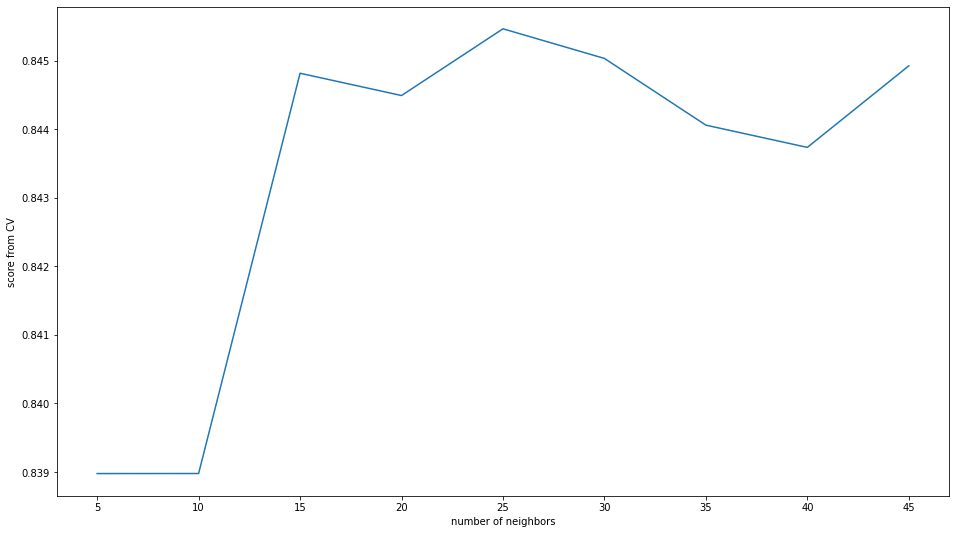

In [24]:
plt.figure(figsize=[16,9])
plt.plot(range(5,50,5),score)
plt.xlabel("number of neighbors")
plt.ylabel("score from CV")
plt.show()

In [25]:
score = []
for i in range (15,30,1):
    once = cross_val_score(KNN(i),Xtrain_PCA,ytrain,cv=5).mean()
    score.append(once)

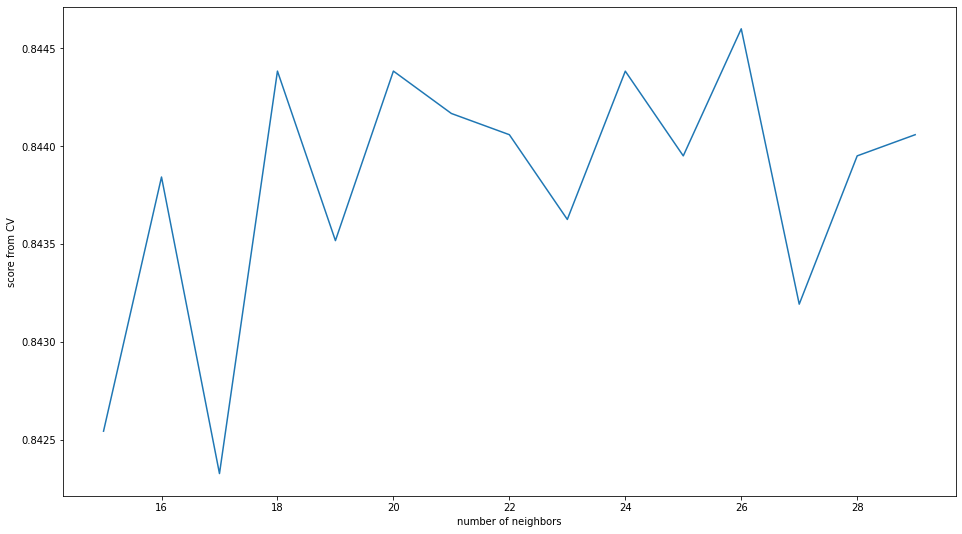

In [26]:
plt.figure(figsize=[16,9])
plt.plot(range(15,30,1),score)
plt.xlabel("number of neighbors")
plt.ylabel("score from CV")
plt.show()

In [27]:
knn_PCA = KNN(18)
knn_PCA.fit(Xtrain_PCA,ytrain)
ytest_knn_PCA = knn_PCA.predict(Xtest_PCA)
err_rate_KNN_PCA = (ytest_knn_PCA!=ytest).sum()/len(ytest)

In [28]:
CM = confusion_matrix(ytest, ytest_knn_PCA)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()

In [29]:
print(np.round(err_rate_KNN_PCA,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_knn_PCA==1).sum()/len(ytest),4))

0.1576
0.1547
TPR: 0.0063 FPR: 0.0046 TNR: 0.9954 FNR: 0.9937
predicted to buy: 0.0049


### Using correlation for feature selection

In [30]:
score = []
for i in range (0,30,5):
    once = cross_val_score(KNN(i+1),Xtrain_corr,ytrain,cv=10).mean()
    score.append(once)

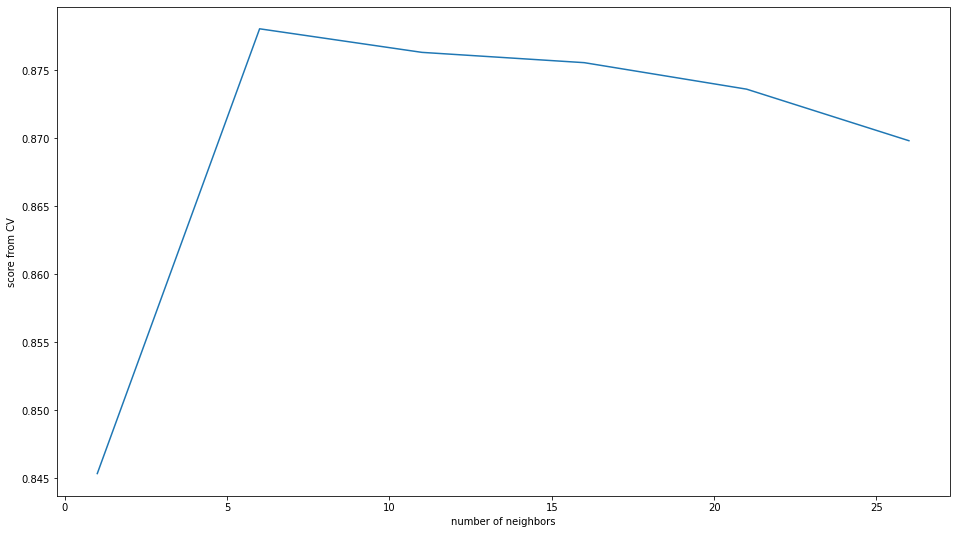

In [31]:
plt.figure(figsize=[16,9])
plt.plot(range(1,31,5),score)
plt.xlabel("number of neighbors")
plt.ylabel("score from CV")
plt.show()

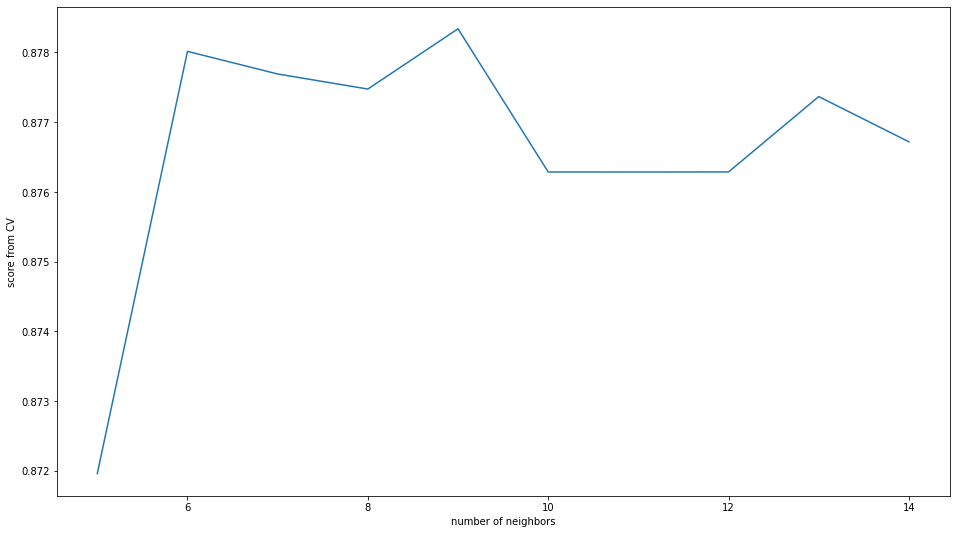

In [32]:
score = []
for i in range (4,14,1):
    once = cross_val_score(KNN(i+1),Xtrain_corr,ytrain,cv=10).mean()
    score.append(once)
    
plt.figure(figsize=[16,9])
plt.plot(range(5,15,1),score)
plt.xlabel("number of neighbors")
plt.ylabel("score from CV")
plt.show()

In [33]:
knn_corr = KNN(9)
knn_corr.fit(Xtrain_corr,ytrain)
ytest_knn_corr = knn_corr.predict(Xtest_corr)
err_rate_KNN_corr = (ytest_knn_corr!=ytest).sum()/len(ytest)

In [34]:
CM = confusion_matrix(ytest, ytest_knn_corr)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()

print(np.round(err_rate_KNN_corr,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_knn_corr==1).sum()/len(ytest),4))

0.1255
0.1547
TPR: 0.3543 FPR: 0.0303 TNR: 0.9697 FNR: 0.6457
predicted to buy: 0.0804


### Using Lasso for feature selection

In [35]:
score = []
for i in range (0,30,5):
    once = cross_val_score(KNN(i+1),Xtrain_lasso,ytrain,cv=10).mean()
    score.append(once)

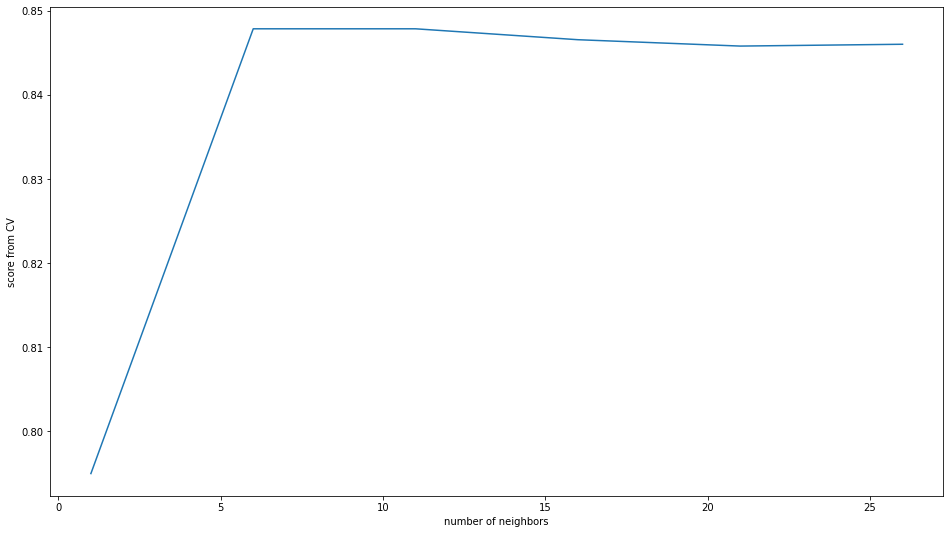

In [36]:
plt.figure(figsize=[16,9])
plt.plot(range(1,31,5),score)
plt.xlabel("number of neighbors")
plt.ylabel("score from CV")
plt.show()

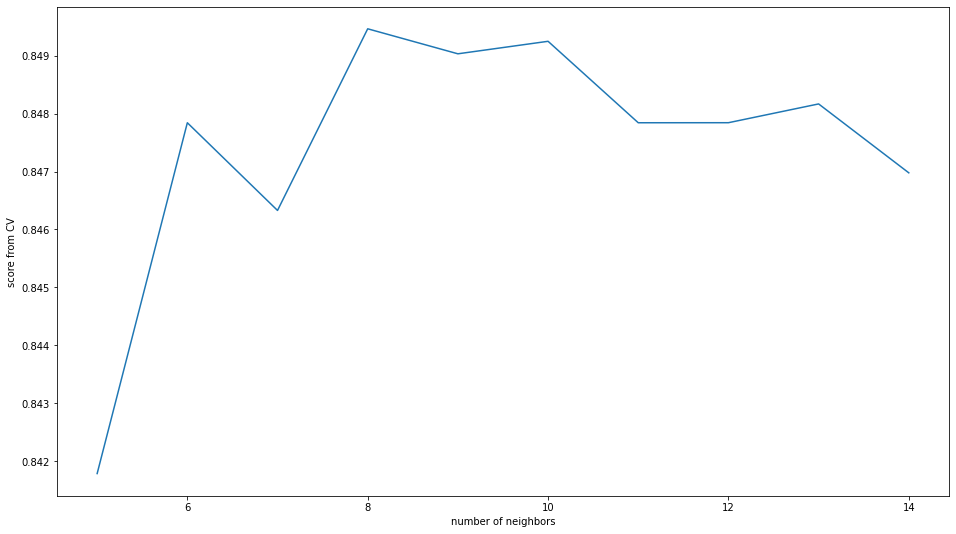

In [37]:
score = []
for i in range (4,14,1):
    once = cross_val_score(KNN(i+1),Xtrain_lasso,ytrain,cv=10).mean()
    score.append(once)
    
plt.figure(figsize=[16,9])
plt.plot(range(5,15,1),score)
plt.xlabel("number of neighbors")
plt.ylabel("score from CV")
plt.show()

In [38]:
knn_lasso = KNN(8)
knn_lasso.fit(Xtrain_lasso,ytrain)
ytest_knn_lasso = knn_lasso.predict(Xtest_lasso)
err_rate_KNN_lasso = (ytest_knn_lasso!=ytest).sum()/len(ytest)

In [39]:
CM = confusion_matrix(ytest, ytest_knn_lasso)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()

print(np.round(err_rate_KNN_lasso,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_knn_lasso==1).sum()/len(ytest),4))

0.1512
0.1547
TPR: 0.065 FPR: 0.0077 TNR: 0.9923 FNR: 0.935
predicted to buy: 0.0165


### Kernel SVM

In [40]:
from sklearn.svm import SVC
from time import time
import datetime

(9247, 2)


<function matplotlib.pyplot.show(*args, **kw)>

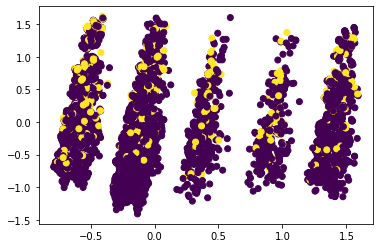

In [41]:
X_dr = PCA(2).fit_transform(Xtrain)
print(X_dr.shape)
plt.scatter(X_dr[:,0],X_dr[:,1],c=ytrain)
plt.show

In [42]:
Kernel = ["linear","rbf","sigmoid"]
 
for kernel in Kernel:
    time0 = time()
    clf= SVC(kernel = kernel
             , gamma="auto"
             , cache_size=10000#MB
            ).fit(Xtrain,ytrain)
    print("The accuracy under kernel %s is %f" % (kernel,clf.score(Xtest,ytest)))
    print(time()-time0)

The accuracy under kernel linear is 0.876419
3.9670259952545166
The accuracy under kernel rbf is 0.845281
4.767705917358398
The accuracy under kernel sigmoid is 0.845281
4.5521931648254395


In [43]:
 for kernel in Kernel:
    time0 = time()
    clf= SVC(kernel = kernel
             , gamma="auto"
             , cache_size=10000#MB
            ).fit(Xtrain_corr,ytrain)
    print("The accuracy under kernel %s is %f" % (kernel,clf.score(Xtest_corr,ytest)))
    print(time()-time0)

The accuracy under kernel linear is 0.876743
1.0568571090698242
The accuracy under kernel rbf is 0.857282
1.4270238876342773
The accuracy under kernel sigmoid is 0.848524
2.0613460540771484


In [44]:
for kernel in Kernel:
    time0 = time()
    clf= SVC(kernel = kernel
             , gamma="auto"
             , cache_size=10000#MB
            ).fit(Xtrain_PCA,ytrain)
    print("The accuracy under kernel %s is %f" % (kernel,clf.score(Xtest_PCA,ytest)))
    print(time()-time0)

The accuracy under kernel linear is 0.845281
1.0533397197723389
The accuracy under kernel rbf is 0.845281
3.2566561698913574
The accuracy under kernel sigmoid is 0.845281
2.60326886177063


In [45]:
for kernel in Kernel:
    time0 = time()
    clf= SVC(kernel = kernel
             , gamma="auto"
             , cache_size=10000#MB
            ).fit(Xtrain_lasso,ytrain)
    print("The accuracy under kernel %s is %f" % (kernel,clf.score(Xtest_lasso,ytest)))
    print(time()-time0)

The accuracy under kernel linear is 0.876095
2.420147180557251
The accuracy under kernel rbf is 0.845929
2.7843661308288574
The accuracy under kernel sigmoid is 0.844956
2.7934939861297607


In [46]:
(ytrain==-1).sum()/len(ytrain)

0.8452471071698929

0.8822575413558222 18.873918221350994


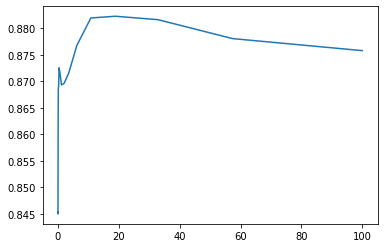

In [47]:
score = []
gamma_range = np.logspace(-5, 2, 30) 
for i in gamma_range:
    clf = SVC(kernel="rbf",gamma = i,cache_size=10000).fit(Xtrain_corr,ytrain)
    score.append(clf.score(Xtest_corr,ytest))
    
print(max(score), gamma_range[score.index(max(score))])
plt.plot(gamma_range,score)
plt.show()


In [48]:
kSVM=SVC(kernel="rbf",gamma=18.874,cache_size=10000)
kSVM.fit(Xtrain_corr,ytrain)
ytest_kSVM = kSVM.predict(Xtest_corr)
err_rate_kSVM = (ytest_kSVM!=ytest).sum()/len(ytest)

In [49]:
CM = confusion_matrix(ytest, ytest_kSVM)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()

print(np.round(err_rate_kSVM,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_kSVM==1).sum()/len(ytest),4))

0.1177
0.1547
TPR: 0.3627 FPR: 0.0226 TNR: 0.9774 FNR: 0.6373
predicted to buy: 0.0753


### Gaussian Kernel SVM with weighted sample

In [53]:
wkSVM=SVC(kernel="rbf",gamma=18.874,cache_size=10000,class_weight={1:6})
wkSVM.fit(Xtrain_corr,ytrain)
ytest_wkSVM = kSVM.predict(Xtest_corr)
err_rate_wkSVM = (ytest_kSVM!=ytest).sum()/len(ytest)

In [54]:
CM = confusion_matrix(ytest, ytest_wkSVM)
TPR = CM[1,1]/CM[1,:].sum()
FPR = CM[0,1]/CM[0,:].sum()
TNR = CM[0,0]/CM[0,:].sum()
FNR = CM[1,0]/CM[1,:].sum()

print(np.round(err_rate_wkSVM,4))
print(np.round((ytest==1).sum()/len(ytest),4))
print("TPR:", np.round(TPR,4),
      "FPR:", np.round(FPR,4),
      "TNR:", np.round(TNR,4),
      "FNR:", np.round(FNR,4))
print("predicted to buy:", np.round((ytest_wkSVM==1).sum()/len(ytest),4))

0.1177
0.1547
TPR: 0.3627 FPR: 0.0226 TNR: 0.9774 FNR: 0.6373
predicted to buy: 0.0753
